## Making Models

This is a notebook that contains a theoretical example that might help to explain how counterfactuals work. The example is not based on a "real dataset" but we might assume that we actually had a dataset that contains information about test scores in a school. The dataset contains three columns: 

- **study**: an indicator if the student in question studied a little, lots or not at all 
- **hard**: an indicator if the test in question was hard 
- **grade**: an indicator if the result of the test was good, a pass or a fail 

We will use this dataset with `brent` to ask some interesting queries.

In [15]:
from brent import Query, DAG, SupposeQuery
from brent.datasets import simple_study_dataset

simple_study_dataset().sample(5)

,study,hard,grade
125,lots,no,good
477,no,yes,fail
112,lots,no,good
480,no,yes,fail
199,lots,no,fail


The first thing we do is load the dataset and give it to a `DAG` object. This object allows us to construct a causal graph of how we believe the world works. In particular one might consider the following causal structure:

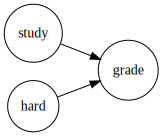

In [3]:
dag = (DAG(dataframe=simple_study_dataset())
       .add_edge("study", "grade")
       .add_edge("hard", "grade"))
dag.plot()

The main assumptions here are: 

- the hardness of the test has a causal influence on the grade
- the amount that the person studied has a causal influence on the grade

It is somewhat easy to determine this relationship because the studying and the hardness of the test are determined before the student takes the test. Creating this graph can be tricky in other scenarios but in this scenario it feels relatively clear. 

## Asking Questions 

Once we've constructed a `DAG` object we can feed it into a `Query` object to construct a query. 

In [4]:
q = Query(dag).given(study="little")

Queries can do two things. For one, they can also create plots. 

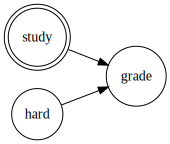

In [5]:
q.plot()

For another, then can calculate probabilities for us.

In [6]:
q.infer()

{'hard': {'no': 0.5, 'yes': 0.5},
 'study': {'little': 1.0},
 'grade': {'fail': 0.30000000000000004,
  'good': 0.44999999999999996,
  'pass': 0.25}}

A more complex query will give us more information about a plot. In the following chart you may notice an arc isn't fully drawn because the influence is now no longer stochastic: it is set. 

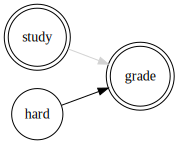

In [10]:
q = Query(dag).given(study="lots", grade="pass")
q.plot()

In [11]:
q.infer()

{'hard': {'no': 0.2307692307692308, 'yes': 0.7692307692307693},
 'study': {'lots': 1.0},
 'grade': {'pass': 1.0}}

## Asking "What-If?"

The two queries we've just asked are useful queries but they belong in the realm of "if I see this, what else would I expect?". This is a useful question but a more interesting question could be: 

"Suppose that I studied a lot and I got a high grade, would I have passed the exam if I had not studied?"

It is the memory of the author that every college student asks her/himself this question all the time. So let us try to get an answer to this question from the model. To ask this question we need a different type of query object: the `SupposeQuery`. The syntax is as follows:

In [12]:
from brent import SupposeQuery
sp = SupposeQuery(dag).when(q).suppose_given(study="little")
sp.infer()

{'hard': {'no': 0.23076923076923075, 'yes': 0.7692307692307692},
 'study': {'little': 0.9999999999999999},
 'grade': {'fail': 0.35384615384615387,
  'good': 0.36923076923076914,
  'pass': 0.2769230769230769}}

Note that the `.infer()` call can also give you back a full marginal table over all the events. 

In [14]:
sp.orig_query.infer(give_table=True)

,hard,study,grade,prob
4,no,lots,pass,0.230769
13,yes,lots,pass,0.769231
